In [3]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split,ValidationCurveDisplay
import sklearn.datasets, sklearn.tree
from sklearn.tree import DecisionTreeClassifier
sns.set(style='white',context='talk',palette='Set1')


In [4]:
df = pd.read_csv("../data/CrabAgePrediction.csv")
df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6
...,...,...,...,...,...,...,...,...,...
3888,F,1.4625,1.1375,0.3250,24.819987,11.651644,5.854172,6.378637,8
3889,F,1.5500,1.2125,0.4375,34.458817,15.450477,7.172423,9.780577,10
3890,I,0.6250,0.4625,0.1625,2.012815,0.765436,0.524466,0.637864,5
3891,I,1.0625,0.7750,0.2625,10.347568,4.507570,2.338834,2.976698,6


<Axes: xlabel='Sex', ylabel='Viscera Weight'>

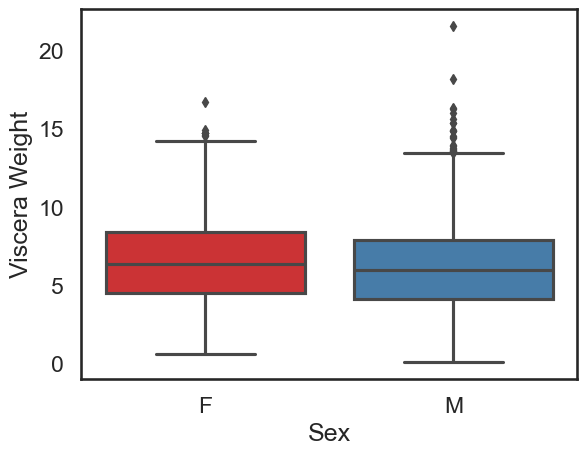

In [18]:
sns.boxplot(data = df, x = 'Sex', y = 'Viscera Weight')

In [12]:
df = df.loc[df.Sex!='I']
X = df.drop(columns=['Sex']) # Features
y = df['Sex'] # Target variable

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) # 70% training and 30% test

In [14]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [15]:
lg.score(X_test,y_test)

0.5551378446115288